# Temperature Tutorial

In this tutorial, we'll run through the basics of generating stream temperature time series predictions. We'll assume that we've already [extracted a collection of representative elementary watersheds (REWs)](network_extraction.ipynb), [paramterized and configured the REWs](parameterize_and_configure.ipynb), [generated hillslope discharge time series](hillslope_discharge.ipynb), and [routed discharge through the channel network](channel_routing.ipynb). 

In [4]:
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
import pandas as pd
import gdal
import os
import datetime
from datetime import timedelta
import numpy as np
import fiona
import shapely
from shapely import geometry
from os.path import dirname
import glob
import seaborn
import sys
import pickle
from functools import partial
import seaborn as sns
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','lib'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','4_temperature'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','3_channel_routing'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','1_data_preparation'))
from temperature import LagrangianSimpleTemperatureChengHeatedGW, ImplicitEulerWesthoff
from channel import TrapezoidalChannel
import meteolib as meteo
import evaplib as evap

# in case any parameters changed
from prep import rew_params
rew_params()
from prep import rew_config
rew_config()
from prep import model_config
model_config()

In [5]:
try:
    basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
except RuntimeError:
    print('Cannot find basins shapefile. Please make sure basins shapefile is located in \n the model directory under /raw_data/basins_poly')

We first need to gain access to all of the parameterization, configuration, hillslope discharge, and routed channel flow data that we've already generated. 

In [6]:
rew_config = pd.read_pickle(os.path.join(parent_dir,'model_data','rew_config.p'), )
climate_group_forcing = pd.read_pickle(os.path.join(parent_dir,'model_data','climate_group_forcing.p'), )
model_config = pd.read_pickle(os.path.join(parent_dir, 'model_data', 'model_config.p'))
temperature_params = pd.read_pickle(os.path.join(parent_dir, 'model_data', 'temperature_params.p'))
temperature_params_ranges = pd.read_pickle(os.path.join(parent_dir, 'model_data', 'temperature_params_ranges.p'))

solved_channel_routing = pd.read_pickle(os.path.join(parent_dir,'model_data','solved_channel_routing.p'))
hill_groups = pd.read_pickle(os.path.join(parent_dir,'model_data','solved_hillslope_discharge.p'))
channel_params = pd.read_pickle(os.path.join(parent_dir,'model_data','channel_params.p'))
radiation = pd.read_pickle(os.path.join(parent_dir, 'raw_data', 'radiation', 'radiation.p'))
ta_ea = pd.read_pickle(os.path.join(parent_dir, 'raw_data', 'ta_ea', 'ta_ea.p'))
# wind = pd.read_pickle(os.path.join(parent_dir, 'raw_data', 'wind', 'wind.p'))

#start/stop dates for running model  
#spinup date is the date after start_date for which we assume model is finished spinning up         
start_date = model_config['start_date']
stop_date = model_config['stop_date']
spinup_date = model_config['spinup_date']
Tmax = model_config['Tmax']
dt = model_config['dt_temperature']
resample_freq_channel = model_config['resample_freq_channel']
resample_freq_hillslope = model_config['resample_freq_hillslope']
resample_freq_temperature = model_config['resample_freq_temperature']
t = np.linspace(0,Tmax,int(np.ceil(Tmax/dt))+1)
timestamps_hillslope = pd.date_range(start_date, stop_date, freq=resample_freq_hillslope)
timestamps_channel = pd.date_range(start_date, stop_date, freq=resample_freq_channel)
timestamps_temperature = pd.date_range(start_date, stop_date, freq=resample_freq_temperature)

With these basic data now loaded, we can instantiate both the channel network and the temperature networks. 

In [7]:
channel_network = {}
for rew_id in rew_config.keys(): 
    args = rew_config[rew_id].copy()
    args.update(channel_params[rew_id])
    channel_network[rew_id] = args['model'](rew_id=rew_id, **args)

temperature_network = {}
for rew_id in rew_config.keys(): 
    args = rew_config[rew_id].copy()
    args.update(temperature_params[rew_id])
    temperature_network[rew_id] = args['model'](rew_id=rew_id, **args)


We simulate the temperature time series beginning with the headwaters, i.e. those with Shreve index 1. These temperature time series are then used as boundary conditions for streams with higher Shreve. 

In [9]:
#Find REW with largest total contributing area
outlet_id = [item for item in rew_config.keys()][0]
area_max = rew_config[outlet_id]['upstream_area']
for rew_id in rew_config.keys():
    if rew_config[rew_id]['upstream_area']>area_max:
        outlet_id = rew_id

rew_ids = rew_config.keys()
shreves = [rew_config[rew_id]['shreve'] for rew_id in rew_ids]
rewQueue = [rew_id for (shreve,rew_id) in sorted(zip(shreves,rew_ids))]
network_temps = {}
network_airtemp = {}
print("Solve REWs in this order:")
print(rewQueue)

for rew_id in rewQueue:
    print('Working on REW ' + str(rew_id))
    shreve  = rew_config[rew_id]['shreve']
    group_id = rew_config[rew_id]['group']
    climate_group_id = group_id[1]
    rew_df = climate_group_forcing[climate_group_id]
    length = channel_network[rew_id].length
    
    Lin = np.array(radiation[rew_id]['Lin'][start_date:stop_date].resample(resample_freq_temperature).interpolate())
    Sin = np.array(radiation[rew_id]['Sin'][start_date:stop_date].resample(resample_freq_temperature).interpolate())
    doy = np.array(radiation[rew_id]['doy'][start_date:stop_date].resample(resample_freq_temperature).ffill())
    
    temp_ea = ta_ea[rew_id].resample(resample_freq_temperature).interpolate()
#     wnd = wind[rew_id].resample(resample_freq_temperature).interpolate()
    ppt_daily = climate_group_forcing[climate_group_id][start_date:stop_date].ppt
    ppt = np.array(climate_group_forcing[climate_group_id][start_date:stop_date].ppt.resample(resample_freq_temperature).ffill())
    ta = np.array(temp_ea['ta'][start_date:stop_date])
    ta_mean = np.array(temp_ea['tmean'][start_date:stop_date])
    ea = np.array(temp_ea['ea'][start_date:stop_date])
#     va = np.array(wnd[start_date:stop_date])
    hillslope_discharge = pd.DataFrame({'discharge':hill_groups[group_id]['discharge']}, index=hill_groups[group_id].index)
    hillslope_overlandFlow = pd.DataFrame({'overlandFlow':hill_groups[group_id]['overlandFlow']}, index=hill_groups[group_id].index)
    
    hillslope_volumetric_overlandFlow = np.array(hillslope_overlandFlow[start_date:stop_date].overlandFlow.resample(resample_freq_temperature).ffill())*rew_config[rew_id]['area_sqcm']
    hillslope_volumetric_discharge = np.array(hillslope_discharge[start_date:stop_date].discharge.resample(resample_freq_temperature).ffill())*rew_config[rew_id]['area_sqcm']
    hillslope_volumetric_discharge_daily = hillslope_discharge[start_date:stop_date].discharge*rew_config[rew_id]['area_sqcm']
    
    width = np.array(solved_channel_routing[rew_id][start_date:stop_date].width.resample(resample_freq_temperature).ffill())
    u = np.array(solved_channel_routing[rew_id][start_date:stop_date].u.resample(resample_freq_temperature).ffill())
    depth = np.array(solved_channel_routing[rew_id][start_date:stop_date].depth.resample(resample_freq_temperature).ffill())

    volumetric_discharge = np.array(solved_channel_routing[rew_id][start_date:stop_date].volumetric_discharge.resample(resample_freq_temperature).ffill())
    volumetric_discharge_daily = solved_channel_routing[rew_id][start_date:stop_date].volumetric_discharge
    temp = np.zeros(np.shape(t))
    
    #get upstream discharges, upstream temperatures

    if shreve == 1:
        vol_1 = np.zeros(np.shape(t))
        vol_2 = np.zeros(np.shape(t))

        temp_1 = np.zeros(np.shape(t))
        temp_2 = np.zeros(np.shape(t))
    else:
        upstream_1 = rew_config[rew_id]['prev_str01']
        upstream_2 = rew_config[rew_id]['prev_str02']

        vol_1 = np.array(solved_channel_routing[upstream_1][start_date:stop_date].volumetric_discharge.resample(resample_freq_temperature).ffill())
        vol_2 = np.array(solved_channel_routing[upstream_2][start_date:stop_date].volumetric_discharge.resample(resample_freq_temperature).ffill())
        
        temp_1 = np.array(network_temps[upstream_1].temperature)
        temp_2 = np.array(network_temps[upstream_2].temperature)

    
    tgw = np.zeros(np.shape(t))
    ta_mean_func = np.zeros(np.shape(t))

    # Now get volumes in channel link. 
    volume = np.array(solved_channel_routing[rew_id][start_date:stop_date].volumes.resample(resample_freq_temperature).interpolate())
    start_temp_model = int(1/dt*(len(pd.date_range(start_date,spinup_date))-365))
    for i in range(len(t)):
        if i<start_temp_model:
            temp[i] = temperature_network[rew_id].temperature
        else:
            varyArgs = ['u','width','ta_mean','vol_1','temp_1','vol_2','temp_2','hillslope_volumetric_discharge', 'hillslope_volumetric_overlandFlow', 'volumetric_discharge', 'volume', 'ta', 'Lin', 'Sin', 'ppt', 'ea', 'doy']
            constArgs = ['length']

            tempArgs = {}
            for arg in varyArgs: tempArgs[arg] = locals()[arg][i]
            for arg in constArgs: tempArgs[arg] = locals()[arg]

            temp[i]=temperature_network[rew_id].temperature
            (tgw[i], ta_mean_func[i]) = temperature_network[rew_id].update(dt, **tempArgs)
    
    network_airtemp[rew_id] = pd.DataFrame({'ta':ta, 'ppt':ppt, 'tgw':tgw, 'ta_mean_func':ta_mean_func}, index=timestamps_temperature)
    network_temps[rew_id] = pd.DataFrame({'temperature':temp},index=timestamps_temperature)

Solve REWs in this order:
[1, 2, 3]
Working on REW 1
Working on REW 2
Working on REW 3


In [10]:
def objective_function(modeled, observed):
    modeled = modeled.resample('D').mean()
    observed = observed.resample('D').mean()
    inds = ((modeled != 0) & (observed != 0))#&((modeled.index.month>=5)&(modeled.index.month<=9))
    if np.sum(modeled)<0.01:
        return -9999.0
    elif np.isnan(np.sum(modeled)):
        return -9999.0
    else:
        return 1-np.sum((observed.loc[inds]-modeled.loc[inds])**2)/np.sum((observed.loc[inds]-np.mean(observed.loc[inds]))**2)

In [11]:
modeled = network_temps[3].temperature.resample(resample_freq).mean().loc['12-2015': '8-2016']
observed = temp_data.temperature.resample(resample_freq).mean().loc['12-2015': '8-2016']
print(objective_function(modeled, observed))
print(np.sqrt(np.mean((modeled-observed)**2)))


NameError: name 'resample_freq' is not defined

In [12]:
resample_freq = 'D'
temp_data = pd.read_pickle(os.path.join(parent_dir, 'calibration_data', 'branscomb_temperature.p'))
modeled = network_temps[19].temperature.resample(resample_freq).mean().loc[spinup_date:stop_date]
modeled2 = network_temps[2].temperature.resample(resample_freq).mean().loc[spinup_date:stop_date]

observed = temp_data.temperature.resample(resample_freq).mean().loc[spinup_date:stop_date]
f, (ax1, ax2) = plt.subplots(2,figsize=(7,5))
ax1.plot(modeled.loc[spinup_date:stop_date])
ax1.plot(observed.loc[spinup_date:stop_date])
# ax1.plot(modeled2.loc[spinup_date:stop_date])

ax1.legend(['model','observe'])

# ax1.plot(network_airtemp[3].tgw,alpha=0.2)
# ax1.plot(network_airtemp[3].ta_mean_func,alpha=0.2)
# ax1.legend(['model','observe', 'tgw', 'ta_mean'])

print(objective_function(modeled, observed))
ax2.set_title('Channel hydro', fontsize=12)
ax1.set_title('Channel temps (validation period)', fontsize=12)

ax2.plot(solved_channel_routing[rew_id][start_date:stop_date].depth, '--k', label='Average channel depth [cm]')
# ax2.plot(solved_channel_routing[rew_id][start_date:stop_date].width/100.0, '-.k', label='Average channel width [m]')
ax3 = ax2.twinx()
ax3.plot(solved_channel_routing[rew_id][start_date:stop_date].u/(100*86400), '--r', label='Average channel velocity [m/s]')
ax2.plot(0,0, '--r', label='Average channel velocity [m/s]')
ax3.tick_params(axis='y', colors='red')

ax2.legend()
ax1.set_ylabel('Temp [C]')
ax1.set_ylim([0,20])
ax1.set_xlim(['12-2015', '8-2016'])
ax2.set_xlim(['12-2015', '8-2016'])
f.tight_layout()
f.savefig('/Users/daviddralle/Desktop/test.pdf')

KeyError: 19

0.797866441873


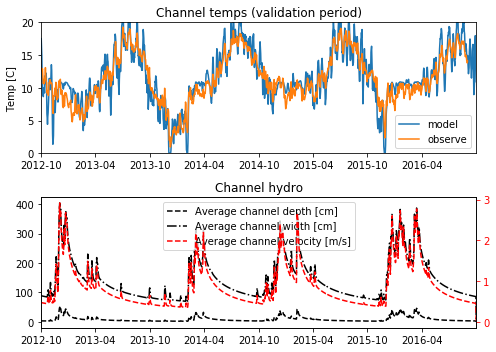

In [26]:
resample_freq = 'D'
temp_data = pd.read_pickle(os.path.join(parent_dir, 'calibration_data', 'elder_temperature.p'))
modeled = network_temps[3].temperature.resample(resample_freq).mean().loc[spinup_date:stop_date]
modeled2 = network_temps[2].temperature.resample(resample_freq).mean().loc[spinup_date:stop_date]

observed = temp_data.temperature.resample(resample_freq).mean().loc[spinup_date:stop_date]
f, (ax1, ax2) = plt.subplots(2,figsize=(7,5))
ax1.plot(modeled.loc[spinup_date:stop_date])
ax1.plot(observed.loc[spinup_date:stop_date])
ax1.legend(['model','observe'])

# ax1.plot(network_airtemp[3].tgw,alpha=0.2)
# ax1.plot(network_airtemp[3].ta_mean_func,alpha=0.2)
# ax1.legend(['model','observe', 'tgw', 'ta_mean'])

print(objective_function(modeled, observed))
ax2.set_title('Channel hydro', fontsize=12)
ax1.set_title('Channel temps (validation period)', fontsize=12)

ax2.plot(solved_channel_routing[rew_id][start_date:stop_date].depth, '--k', label='Average channel depth [cm]')
ax2.plot(solved_channel_routing[rew_id][start_date:stop_date].width, '-.k', label='Average channel width [cm]')
ax3 = ax2.twinx()
ax3.plot(solved_channel_routing[rew_id][start_date:stop_date].u/(100*86400), '--r', label='Average channel velocity [m/s]')
ax2.plot(0,0, '--r', label='Average channel velocity [m/s]')
ax3.tick_params(axis='y', colors='red')

ax2.legend()
ax1.set_ylabel('Temp [C]')
ax1.set_ylim([0,20])
ax1.set_xlim([spinup_date, stop_date])
ax2.set_xlim([spinup_date, stop_date])
f.tight_layout()
# f.savefig('/Users/daviddralle/Desktop/test.pdf')

In [9]:
# # check balance of an individual channel 
# network_volumetric_discharges = pickle.load( open( os.path.join(parent_dir,'model_data','solved_channel_routing.p'), "rb" ) )

# rew=3
# stream = network_volumetric_discharges[rew].volumes
# length = channel_network[rew].length
# width = channel_network[rew].width
# area = length*width
# group = rew_config[rew]['group']
# climate_group_id = group_id[1]
# ppt = climate_group_forcing[climate_group_id][start_date:stop_date].ppt*area 
# hillslope_discharge = pd.DataFrame({'discharge':hill_groups[group_id]['discharge']}, index=hill_groups[group_id].index)
# hillslope_overlandFlow = pd.DataFrame({'overlandFlow':hill_groups[group_id]['overlandFlow']}, index=hill_groups[group_id].index)
# hillslope_discharge['discharge'] = hillslope_discharge['discharge'] + hillslope_overlandFlow['overlandFlow']
# hillslope_volumetric_discharge = hillslope_discharge[start_date:stop_date].discharge*rew_config[rew]['area_sqcm']


# outDis = network_volumetric_discharges[rew].volumetric_discharge
# cumOutDis = outDis.cumsum() 

# upstream_1 = rew_config[rew]['prev_str01']
# upstream_2 = rew_config[rew]['prev_str02']
# try:
#     vol_1 = network_volumetric_discharges[upstream_1].volumetric_discharge#.resample(resample_freq_channel).ffill()
#     vol_2 = network_volumetric_discharges[upstream_2].volumetric_discharge#.resample(resample_freq_channel).ffill()
#     inDis = vol_1 + vol_2 + hillslope_volumetric_discharge
# except:
#     inDis = hillslope_volumetric_discharge
        

# cumInDis = inDis.cumsum()

# cumPpt = ppt.cumsum()


# S0 = stream[0] + cumOutDis[0] - cumPpt[0] - cumInDis[0]
# totalIn = cumPpt + cumInDis
# S =  stream
# totalOut = cumOutDis
# balance = (totalIn - totalOut + S0)/S
# plt.plot(balance[0:-2])
# plt.ylim([0,1.1])
# print(np.max(balance[0:-2]))
# print(np.min(balance[0:-2]))

In [10]:

# rew = 3
# group_id = rew_config[rew]['group']
# climate_group_id = group_id[1]
# network_volumetric_discharges = pickle.load( open( os.path.join(parent_dir,'model_data','solved_channel_routing.p'), "rb" ) )

# # volume in outlet rew stream
# stream = network_volumetric_discharges[rew].volumes.resample(resample_freq_temperature).interpolate()
# width = network_volumetric_discharges[rew].width[0]
# length = network_volumetric_discharges[rew].length[0]

# # volumetric discharge leaving rew stream
# volumetric_discharge = network_volumetric_discharges[rew].volumetric_discharge.resample(resample_freq_temperature).bfill()

# # precip on channel
# area = width*length
# ppt = climate_group_forcing[climate_group_id][start_date:stop_date].ppt.resample(resample_freq_temperature).bfill()*area 

# # incoming hillslope discharge 
# hillslope_discharge = pd.DataFrame({'discharge':hill_groups[group_id]['discharge']}, index=hill_groups[group_id].index)
# hillslope_volumetric_discharge = hillslope_discharge[start_date:stop_date].discharge.resample(resample_freq_temperature).bfill()*rew_config[rew]['area_sqcm']

# # volumetric discharges from upstream
# upstream_1 = rew_config[rew]['prev_str01']
# upstream_2 = rew_config[rew]['prev_str02']            
# vol_1 = network_volumetric_discharges[upstream_1].volumetric_discharge.resample(resample_freq_temperature).bfill()
# vol_2 = network_volumetric_discharges[upstream_2].volumetric_discharge.resample(resample_freq_temperature).bfill()
                                          
# cumPpt = np.cumsum(ppt)*dt
# cumInDis = np.cumsum(vol_1 + vol_2 + hillslope_volumetric_discharge)*dt
# cumOutDis = np.cumsum(volumetric_discharge)*dt

# S0 = stream[0] - cumInDis[0] + cumOutDis[0] - cumPpt[0]
# S = stream
# totalIn = cumPpt + cumInDis
# totalOut = cumOutDis
# balance = (totalIn - totalOut + S0)/S
# print(np.max(balance[0:-int(1/dt)]))
# print(np.min(balance[0:-int(1/dt)]))
# plt.plot(balance[0:-int(1/dt)])